In [1]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
from geopy.distance import geodesic
import joblib

# Transformador personalizado
class CustomTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        
        X['Hour'] = X['trans_date_trans_time'].dt.hour
        X['month'] = X['trans_date_trans_time'].dt.month
        X['year']= X['trans_date_trans_time'].dt.year
        X['day_of_week']= X['trans_date_trans_time'].dt.day_of_week
        X['is_weekend']= X['trans_date_trans_time'].dt.day_of_week >= 5 
        X['idade']= X['trans_date_trans_time'].dt.year - X['dob'].dt.year

        def distance(row):
            return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km

        X['distance'] = X.apply(distance, axis=1)

        X.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True, errors='ignore')

        def get_period_of_day(hour):
            if 6 <= hour < 12:
                return 'Manhã'
            elif 12 <= hour < 18:
                return 'Tarde'
            elif 18 <= hour < 24:
                return 'Noite'
            else:
                return 'Madrugada'

        X['period_of_day'] = X['Hour'].apply(get_period_of_day)

        X['trans_count_month'] = X.groupby(['cc_num', 'year', 'month'])['trans_num'].transform('count')
        X['total_amt_month'] = X.groupby(['cc_num', 'year', 'month'])['amt'].transform('sum')
        X['avg_amt_month'] = X['total_amt_month'] / X['trans_count_month']
        X['amt_city_pop_ratio'] = X['amt'] / X['city_pop']
        X['amt_distance_ratio'] = X['amt'] / X['distance']
        X=X.fillna('False')
        X.drop(columns=['merch_long', 'merch_lat', 'long', 'lat', 'dob', 'trans_date_trans_time', 'last', 'first', 'zip', 'trans_num', 'unix_time'], inplace=True, errors='ignore')

        return X

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.distance import geodesic

In [4]:
df = pd.read_csv("fraudValidate.csv")
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

In [6]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])

In [7]:
df= df.dropna()

In [8]:
#verificar duplicadas
df.duplicated().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249308 entries, 0 to 270350
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0.1           249308 non-null  int64         
 1   Unnamed: 0             249308 non-null  int64         
 2   trans_date_trans_time  249308 non-null  datetime64[ns]
 3   cc_num                 249308 non-null  float64       
 4   merchant               249308 non-null  object        
 5   category               249308 non-null  object        
 6   amt                    249308 non-null  float64       
 7   first                  249308 non-null  object        
 8   last                   249308 non-null  object        
 9   gender                 249308 non-null  object        
 10  street                 249308 non-null  object        
 11  city                   249308 non-null  object        
 12  state                  249308 non-null  object   

In [1]:
#criando colunas com base na data de transação

df['Hour'] = df['trans_date_trans_time'].dt.hour
df['month'] = df['trans_date_trans_time'].dt.month
df['year']= df['trans_date_trans_time'].dt.year
df['day_of_week']= df['trans_date_trans_time'].dt.day_of_week
df['is_weekend']= df['trans_date_trans_time'].dt.day_of_week >= 5 
df['idade']= df['trans_date_trans_time'].dt.year - df['dob'].dt.year


NameError: name 'df' is not defined

In [11]:
df[['Hour','month','year','day_of_week','is_weekend','idade']]

,Hour,month,year,day_of_week,is_weekend,idade
0,0,1,2019,1,False,26
1,0,1,2019,1,False,78
2,0,1,2019,1,False,45
4,0,1,2019,1,False,73
5,0,1,2019,1,False,55
...,...,...,...,...,...,...
270346,23,12,2020,3,False,19
270347,23,12,2020,3,False,79
270348,23,12,2020,3,False,24
270349,23,12,2020,3,False,37


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249308 entries, 0 to 270350
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0.1           249308 non-null  int64         
 1   Unnamed: 0             249308 non-null  int64         
 2   trans_date_trans_time  249308 non-null  datetime64[ns]
 3   cc_num                 249308 non-null  float64       
 4   merchant               249308 non-null  object        
 5   category               249308 non-null  object        
 6   amt                    249308 non-null  float64       
 7   first                  249308 non-null  object        
 8   last                   249308 non-null  object        
 9   gender                 249308 non-null  object        
 10  street                 249308 non-null  object        
 11  city                   249308 non-null  object        
 12  state                  249308 non-null  object   

In [13]:
#calculando distancia registrada no cartao com mercante

def distance(row):
    return geodesic((row['lat'],row['long']),(row['merch_lat'],row['merch_long'])).km

df['distance']= df.apply(distance, axis=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249308 entries, 0 to 270350
Data columns (total 31 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Unnamed: 0.1           249308 non-null  int64         
 1   Unnamed: 0             249308 non-null  int64         
 2   trans_date_trans_time  249308 non-null  datetime64[ns]
 3   cc_num                 249308 non-null  float64       
 4   merchant               249308 non-null  object        
 5   category               249308 non-null  object        
 6   amt                    249308 non-null  float64       
 7   first                  249308 non-null  object        
 8   last                   249308 non-null  object        
 9   gender                 249308 non-null  object        
 10  street                 249308 non-null  object        
 11  city                   249308 non-null  object        
 12  state                  249308 non-null  object   

In [15]:
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [16]:
def get_period_of_day(hour):
    if 6 <= hour < 12:
        return 'Manhã'
    elif 12 <= hour < 18:
        return 'Tarde'
    elif 18 <= hour < 24:
        return 'Noite'
    else:
        return 'Madrugada'

df['period_of_day'] = df['Hour'].apply(get_period_of_day)

In [17]:
df['month'] = df['trans_date_trans_time'].dt.month
df['year'] = df['trans_date_trans_time'].dt.year
df['trans_count_month'] = df.groupby(['cc_num', 'year', 'month'])['trans_num'].transform('count')


In [18]:
df['total_amt_month'] = df.groupby(['cc_num', 'year', 'month'])['amt'].transform('sum')
df['avg_amt_month'] = df['total_amt_month'] / df['trans_count_month']
df['avg_amt_month'] = df['total_amt_month'] / df['trans_count_month']


In [19]:
df['amt_city_pop_ratio'] = df['amt'] / df['city_pop']

In [20]:
df['amt_distance_ratio'] = df['amt'] / df['distance']

# Finalizando

In [21]:
df_final= df.copy()
df_final.drop(columns=['merch_long','merch_lat','long','lat','dob','trans_date_trans_time','last','first','zip','trans_num','unix_time'], inplace=True)

In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249308 entries, 0 to 270350
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cc_num              249308 non-null  float64
 1   merchant            249308 non-null  object 
 2   category            249308 non-null  object 
 3   amt                 249308 non-null  float64
 4   gender              249308 non-null  object 
 5   street              249308 non-null  object 
 6   city                249308 non-null  object 
 7   state               249308 non-null  object 
 8   city_pop            249308 non-null  int64  
 9   job                 249308 non-null  object 
 10  is_fraud            249308 non-null  int64  
 11  Hour                249308 non-null  int32  
 12  month               249308 non-null  int32  
 13  year                249308 non-null  int32  
 14  day_of_week         249308 non-null  int32  
 15  is_weekend          249308 non-null  bo

In [23]:
columns_to_dummify = ['merchant', 'category','gender','street','city','state','period_of_day','job']
dummies = pd.get_dummies(df_final[columns_to_dummify])
df_result = pd.concat([df_final.drop(columns_to_dummify, axis=1), dummies], axis=1)


In [24]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249308 entries, 0 to 270350
Columns: 1201 entries, cc_num to job_Warden/ranger
dtypes: bool(1186), float64(7), int32(5), int64(3)
memory usage: 307.7 MB


In [25]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate

In [26]:
df_result['is_fraud']

0         0
1         0
2         0
4         0
5         0
         ..
270346    0
270347    0
270348    0
270349    0
270350    0
Name: is_fraud, Length: 249308, dtype: int64

In [27]:
x= df_result
x.drop(columns=['is_fraud'])

y= df_result['is_fraud']


In [28]:
#dummy classifier
from sklearn.model_selection import train_test_split
treino_x,teste_x,treino_y,teste_y= train_test_split(x,y,stratify=y,test_size=0.25)
from sklearn.dummy import DummyClassifier
dummy_stratified= DummyClassifier()
dummy_stratified.fit(treino_x,treino_y)
print(f"{dummy_stratified.score(teste_x,teste_y)*100}%" )

99.443258940748%


In [29]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249308 entries, 0 to 270350
Columns: 1201 entries, cc_num to job_Warden/ranger
dtypes: bool(1186), float64(7), int32(5), int64(3)
memory usage: 307.7 MB


#FINAL

In [30]:
def imprime_resultados(results):
  media=results['test_score'].mean()
  desvio_padrao= results['test_score'].std()
  print("accuracy %.4f" % (media*100))
  print("Accuracy com cross validation, 10 = [%.5f, %.5f]" % ((media - 2 * desvio_padrao)*100, media + 2 * desvio_padrao))

In [31]:
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
modelo = DecisionTreeClassifier(max_depth=4)
results = cross_validate(modelo,x,y,cv=5,scoring='accuracy', return_train_score=False)
imprime_resultados(results)

accuracy 100.0000
Accuracy com cross validation, 10 = [100.00000, 1.00000]


In [32]:
from sklearn.metrics import accuracy_score
modelo.fit(x,y)
previsoes=modelo.predict(teste_x)
previsoes=modelo.predict(teste_x)
accuracy_score(teste_y, previsoes)

1.0

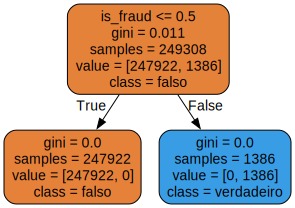

In [33]:
from sklearn.tree import export_graphviz
import graphviz
modelo.fit(x, y)
features=x.columns
dot_data = export_graphviz(modelo,out_file=None,filled=True,rounded=True,class_names=["falso", "verdadeiro"],feature_names=features)
graph= graphviz.Source(dot_data)
graph


In [34]:
#dummy classifier
from sklearn.model_selection import train_test_split
treino_x,teste_x,treino_y,teste_y= train_test_split(x,y,stratify=y,test_size=0.25)
from sklearn.dummy import DummyClassifier
dummy_stratified= DecisionTreeClassifier(max_depth=4)
dummy_stratified.fit(treino_x,treino_y)
print(f"{dummy_stratified.score(teste_x,teste_y)*100}%" )

100.0%


#Deploy

In [36]:
import pickle
import os
pickle.dump(modelo, open(os.path.join('models','primeiro-modelo-arvore-decisao.pkl'),'wb'))

#Pipeline

In [10]:
df = pd.read_csv("fraudValidate.csv")
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])
df= df.dropna()

In [7]:
#Estimator
from sklearn.base import BaseEstimator, TransformerMixin
class Transformer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X['trans_date_trans_time'] = pd.to_datetime(X['trans_date_trans_time'])
        X['dob'] = pd.to_datetime(X['dob'])
        X['Hour'] = X['trans_date_trans_time'].dt.hour
        X['month'] = X['trans_date_trans_time'].dt.month
        X['year']= X['trans_date_trans_time'].dt.year
        X['day_of_week']= X['trans_date_trans_time'].dt.day_of_week
        X['is_weekend']= X['trans_date_trans_time'].dt.day_of_week >= 5 
        X['idade']= X['trans_date_trans_time'].dt.year - X['dob'].dt.year

        def distance(row):
            return geodesic((row['lat'],row['long']),(row['merch_lat'],row['merch_long'])).km

        X['distance']= X.apply(distance, axis=1)

        X.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

        def get_period_of_day(hour):
            if 6 <= hour < 12:
                return 'Manhã'
            elif 12 <= hour < 18:
                return 'Tarde'
            elif 18 <= hour < 24:
                return 'Noite'
            else:
                return 'Madrugada'

        X['period_of_day'] = X['Hour'].apply(get_period_of_day)

        X['month'] = X['trans_date_trans_time'].dt.month
        X['year'] = X['trans_date_trans_time'].dt.year
        X['trans_count_month'] = X.groupby(['cc_num', 'year', 'month'])['trans_num'].transform('count')

        X['total_amt_month'] = X.groupby(['cc_num', 'year', 'month'])['amt'].transform('sum')
        X['avg_amt_month'] = X['total_amt_month'] / X['trans_count_month']
        X['avg_amt_month'] = X['total_amt_month'] / X['trans_count_month']

        X['amt_city_pop_ratio'] = X['amt'] / X['city_pop']

        X['amt_distance_ratio'] = X['amt'] / X['distance']

        X.drop(columns=['merch_long','merch_lat','long','lat','dob','trans_date_trans_time','last','first','zip','trans_num','unix_time'], inplace=True)

        columns_to_dummify = ['merchant', 'category','gender','street','city','state','period_of_day','job']
        dummies = pd.get_dummies(X[columns_to_dummify])
        X_result = pd.concat([X.drop(columns_to_dummify, axis=1), dummies], axis=1)
       
        X_result = pd.concat([X.drop(columns=categorical_features), X_encoded_df], axis=1)
        return X_result

In [8]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('Transform',Transformer),('Model',DecisionTreeClassifier())])

NameError: name 'DecisionTreeClassifier' is not defined

In [ ]:
dropper= Transformer()
df= dropper.fit_transform(df)


In [55]:

from sklearn.model_selection import train_test_split
x=df.drop(['is_fraud'],axis=1)
y=df['is_fraud']
treino_x,teste_x,treino_y,teste_y= train_test_split(x,y,stratify=y,test_size=0.25)


pipeline.fit(treino_x,treino_y)
#print(f"{pipeline.score(teste_x,teste_y)*100}%" )

Pipeline(steps=[('custom', CustomTransformer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant', 'category',
                                                   'gender', 'street', 'city',
                                                   'state', 'period_of_day',
                                                   'job']),
                                                 ('num', SimpleImputer(),
                                                  ['distance', 'idade',
                                                   'amt_city_pop_ratio',
                                                   'amt_distance_ratio',
                                                   'trans_count_month',
                                                   'total_amt_month',
                                                   'avg_amt_month'])])),
                ('classifier', DecisionTreeClassifier(max_depth=4))])

#Transformer Final

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
from geopy.distance import geodesic
import joblib

# Transformador personalizado
class CustomTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        
        X['Hour'] = X['trans_date_trans_time'].dt.hour
        X['month'] = X['trans_date_trans_time'].dt.month
        X['year']= X['trans_date_trans_time'].dt.year
        X['day_of_week']= X['trans_date_trans_time'].dt.day_of_week
        X['is_weekend']= X['trans_date_trans_time'].dt.day_of_week >= 5 
        X['idade']= X['trans_date_trans_time'].dt.year - X['dob'].dt.year

        def distance(row):
            return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km

        X['distance'] = X.apply(distance, axis=1)

        X.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True, errors='ignore')

        def get_period_of_day(hour):
            if 6 <= hour < 12:
                return 'Manhã'
            elif 12 <= hour < 18:
                return 'Tarde'
            elif 18 <= hour < 24:
                return 'Noite'
            else:
                return 'Madrugada'

        X['period_of_day'] = X['Hour'].apply(get_period_of_day)

        X['trans_count_month'] = X.groupby(['cc_num', 'year', 'month'])['trans_num'].transform('count')
        X['total_amt_month'] = X.groupby(['cc_num', 'year', 'month'])['amt'].transform('sum')
        X['avg_amt_month'] = X['total_amt_month'] / X['trans_count_month']
        X['amt_city_pop_ratio'] = X['amt'] / X['city_pop']
        X['amt_distance_ratio'] = X['amt'] / X['distance']
        X=X.fillna('False')
        X.drop(columns=['merch_long', 'merch_lat', 'long', 'lat', 'dob', 'trans_date_trans_time', 'last', 'first', 'zip', 'trans_num', 'unix_time'], inplace=True, errors='ignore')

        return X

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['merchant', 'category', 'gender', 'street', 'city', 'state', 'period_of_day', 'job']),
        ('num', SimpleImputer(strategy='mean'), ['distance', 'idade', 'amt_city_pop_ratio', 'amt_distance_ratio', 'trans_count_month', 'total_amt_month', 'avg_amt_month'])
    ],
    remainder='passthrough'
)

# Pipeline Cria
pipeline = Pipeline(steps=[
    ('custom', CustomTransformer()),
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=4))
])


In [14]:
from sklearn.model_selection import train_test_split
x=df.drop(columns=['is_fraud'])
y=df['is_fraud']
treino_x,teste_x,treino_y,teste_y= train_test_split(x,y,stratify=y,test_size=0.25)


pipeline.fit(treino_x,treino_y)

Pipeline(steps=[('custom', CustomTransformer()),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['merchant', 'category',
                                                   'gender', 'street', 'city',
                                                   'state', 'period_of_day',
                                                   'job']),
                                                 ('num', SimpleImputer(),
                                                  ['distance', 'idade',
                                                   'amt_city_pop_ratio',
                                                   'amt_distance_ratio',
                                                   'trans_count_month',
                                                   'total_amt_month',
                                                   'avg_amt_month'])])),
                ('classifier', DecisionTreeClassifier(max_depth=4))])

In [15]:
print(pipeline.score(teste_x, teste_y))

0.991528551029249


In [16]:
from sklearn.model_selection import cross_validate
x= df
x.drop(columns=['is_fraud'])
y= df['is_fraud']

results = cross_validate(pipeline,x,y,cv=5,scoring='accuracy', return_train_score=False)
imprime_resultados(results)

NameError: name 'imprime_resultados' is not defined

In [17]:

predictions = pipeline.predict(teste_x)
print(f"Acurácia: {accuracy_score(teste_y, predictions) * 100}%")

Acurácia: 99.1528551029249%


In [65]:
import pickle
import os
pickle.dump(pipeline, open(os.path.join('models','pipeline_2.pkl'),'wb'))

In [18]:
from joblib import dump

# Salva a pipeline em um arquivo .pkl
dump(pipeline, 'pipeline_3.pkl')


['pipeline_3.pkl']

In [ ]:
import pandas as pd
import numpy as np
import psycopg2
import pandas as pd
import pandas.io.sql as psql
from sqlalchemy import create_engine, text
import yaml
from pathlib import Path
import sys
import os

import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score
from sklearn.pipeline import Pipeline

project_dir = Path('__main__').resolve().parent.parent
sys.path.append(os.path.join(project_dir, 'src'))


pickle.dump(pipe, open(os.path.join(project_dir, 'models', 'pipeline-model_2.pkl'), 'wb'))